In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
import networkx as nx
from networkx.algorithms import bipartite
# import community
from networkx.readwrite import json_graph
# import nx_altair as nxa
from networkx.algorithms.community import greedy_modularity_communities
from pyvis import network as net
# from node2vec import Node2Vec
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import itertools
import collections
from tqdm.notebook import trange, tqdm

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("..")
from network_analysis.load_datasets import get_updated_shxco_data
from network_analysis.generate_network_metrics import *
from network_analysis.create_networks import *
from network_analysis.read_write_networks import * 
members_df, books_df, borrow_events, events_df = get_updated_shxco_data()


In [2]:
all_events = borrow_events.copy()
all_events = all_events.loc[all_events.start_datetime < '1925-01-01']
unexceptional_events = borrow_events[borrow_events.exceptional_types.isna()]



In [3]:
member_attrs = {'uri': 'member_id'}
book_attrs = {'uri': 'item_uri'}
edge_attrs = {'weight': 'counts'}
node_attrs = {}
should_process = True
write_to_file = True
sk_metrics = ['katz', 'louvain']
link_metrics = ['pagerank', 'hubs', 'auth']
is_projected = True
all_events_grouped = all_events.groupby(
    ['member_id', 'item_uri']).size().reset_index(name='counts')
unexceptional_events_grouped = unexceptional_events.groupby(
    ['member_id', 'item_uri']).size().reset_index(name='counts')


projected_members_graph, projected_members_nodelist, projected_members_edgelist, projected_members, projected_books_graph, projected_books_nodelist, projected_books_edgelist, projected_books = check_reload_build_unipartite_graphs(
    all_events_grouped, all_events, member_attrs, book_attrs, edge_attrs, node_attrs, should_process, write_to_file, './data/all_events_unipartite_projected', sk_metrics, link_metrics, members_df, books_df, is_projected)


reloading saved graph: ./data/all_events_unipartite_projected


In [22]:
def update_edge_labels(rows, nodes_df):

    return nodes_df[nodes_df.label == rows].label.values[0]


def get_link_predictions(graph, nodelist, edgelist):
    jaccard_coefs = list(nx.jaccard_coefficient(graph))
    jaccard_df = pd.DataFrame(jaccard_coefs, columns=['source', 'target', 'jaccard_coef_prediction'])
    

    print(len(jaccard_df))

    pref_attach = nx.preferential_attachment(projected_members_graph)
    pref_attach_df = pd.DataFrame(list(pref_attach), columns=['source', 'target', 'preferential_attachment_prediction'])
    print(len(pref_attach_df))

    # pred_df['updated_target'] = pred_df.target.apply(update_edge_labels, nodes_df=nodelist)
    # pred_df['updated_source'] = pred_df.source.apply(update_edge_labels, nodes_df=nodelist)

get_link_predictions(projected_members_graph, projected_members_nodelist, projected_members_edgelist)


123649
123649


<generator object _apply_prediction.<locals>.<genexpr> at 0x171beb740>

In [14]:
components = [c for c in sorted(
    nx.connected_components(projected_members_graph), key=len, reverse=True)]

preds_dfs = []
for c in components:
    subgraph = projected_members_graph.subgraph(c)
    # print(len(subgraph))
    preds = nx.common_neighbor_centrality(subgraph)
    pred_df = pd.DataFrame(
        list(preds), columns=['source', 'target', 'common_neighbor_centrality_prediction'])
    preds_dfs.append(pred_df)


525
1
1
1
1
1
1
1
1
1
1
1


In [16]:
preds = list(nx.resource_allocation_index(projected_members_graph))


pred_df = pd.DataFrame(preds, columns=['source', 'target', 'resource_allocation_prediction'])


In [176]:
def update_edge_labels(rows):

    return nodes_df[nodes_df.label == rows].label.values[0]
pred_df['updated_target'] = pred_df.target.apply(update_edge_labels)
pred_df['updated_source'] = pred_df.source.apply(update_edge_labels)


In [17]:
partial_df = pd.read_csv('../dataset_generator/data/partial_borrowers.csv')
partial_df[0:1]


,member_id,subscription_start,subscription_end,known_borrows
0,martin-maud,1927-03-19,1927-06-19,36


In [20]:
members = projected_members.copy()
partial_members = partial_df.member_id.unique().tolist()
members.loc[(members.exceptional_types.isna() == True),
            'is_exceptional'] = False
members.loc[(members.exceptional_types.isna() == False),
            'is_exceptional'] = True
members.loc[(members.member_id.isin(partial_members)), 'is_partial'] = True
members.loc[(members.member_id.isin(partial_members)
             == False), 'is_partial'] = False


In [94]:
members = all_events[all_events.start_datetime < '1925-01-01'].member_id.unique().tolist()
books = all_events[all_events.start_datetime <'1925-01-01'].item_uri.unique().tolist()


In [95]:
combos = list(itertools.product(members, books))
len(combos)

91287

In [132]:
combo_df = pd.DataFrame(data=combos, columns=['source', 'target'])


In [133]:
edgelist = pd.merge(combo_df, edges_df, on=['source', 'target'], how='outer')
edgelist.weight.fillna(0, inplace=True)

In [134]:
nodelist = pd.merge(members_df[['gender', 'is_organization', 'member_id', 'borrow_count', 'subscription_count', 'exceptional_types',
            'exceptional_counts']], nodes_df, left_on='member_id', right_on='uri')


In [137]:
import random
training = edgelist[edgelist.weight > 0 ].sample(frac=0.5)


In [136]:
# Degree Centrality features
# out_degree_centrality = nx.out_degree_centrality(members_graph)
# in_degree_centrality = nx.in_degree_centrality(members_graph)
# # training['source_out_centrality'] = training.apply(lambda row: degree_centrality[row.source],axis=1)
# # training['target_in_centrality'] = training.apply(lambda row: in_degree_centrality[row.target],axis=1)

# # Page rank
page_rank = nx.pagerank_scipy(members_graph)
training['target_pagerank'] = training.apply(lambda row: page_rank[row.target],axis=1)

# # Preferential Attachment
# # For a directed graph, is equal to K_out_source * K_in_target with K the number of neighbors. Which is equivalent to multiply the available centralities.
# training['preferencial_attachment'] = training.apply(lambda row: row.source_out_centrality * row.target_in_centrality,axis=1)

# # HITS algorithm
hub_score, authority_score = nx.hits(members_graph)
training['source_hub_score'] = training.apply(lambda row: hub_score[row.source],axis=1)
training['target_authority_score'] = training.apply(lambda row: authority_score[row.target],axis=1)


KeyError: 'cannan-time-eternity-tale'

<AxesSubplot:>

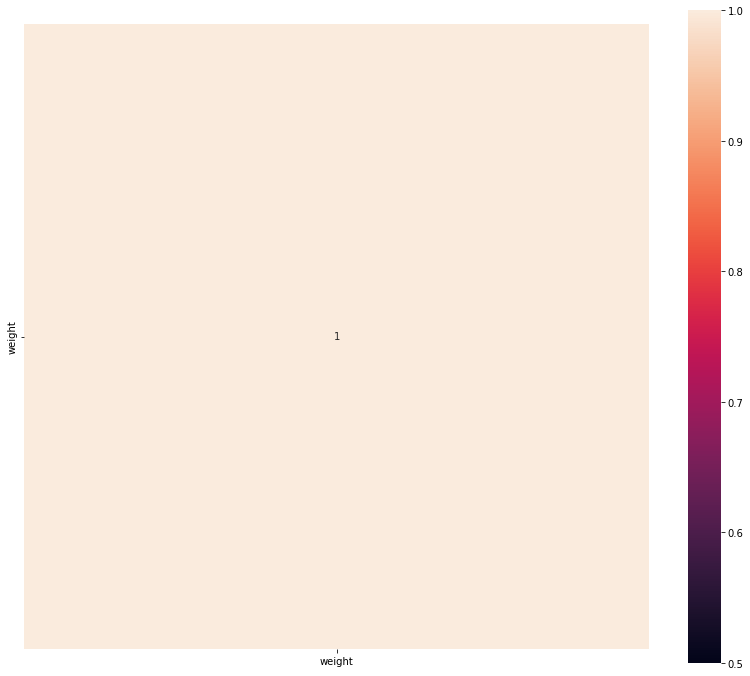

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 12))
sns.heatmap(training.corr(),
            vmax=0.5,
            square=True,
            annot=True)


In [139]:
training.loc[training.weight > 0, 'edge_exists'] = 1
training.loc[training.weight == 0, 'edge_exists'] = 0

In [140]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training.drop(
    ['source', 'target', 'edge_exists'], axis=1), training.edge_exists, test_size=0.2)


In [141]:
from sklearn.ensemble import RandomForestClassifier

RF_classifer = RandomForestClassifier(n_estimators=1000)
RF_classifer.fit(X_train, y_train)


RandomForestClassifier(n_estimators=1000)

In [116]:
# rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#                        max_depth=None, max_features='auto', max_leaf_nodes=None,
#                        min_impurity_decrease=0.0,
#                        min_samples_leaf=1, min_samples_split=2,
#                        min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
#                        oob_score=False, random_state=None, verbose=0,
#                        warm_start=False)


In [142]:
RF_classifer.score(X_test, y_test)


1.0

In [143]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100,
                           n_jobs=-1,
                           oob_score=True,
                           bootstrap=True,
                           random_state=42)
rf.fit(X_train, y_train)


RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=42)

In [144]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), rf.oob_score_,rf.score(X_test, y_test)))


R^2 Training Score: 1.00 
OOB Score: 1.00 
R^2 Validation Score: 1.00
